# Principal Component Analysis (PCA)

An unsupervised method for dimensionality reduction in data

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

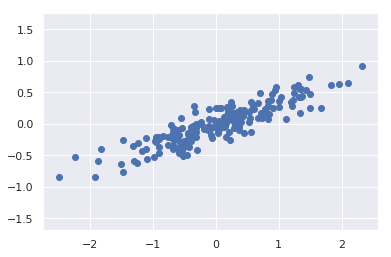

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

Instead of attempting to predict the y values from the x values (regression), the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


"components" define the direction of the vector, and "explained variance" define the squared-length of the vector.

These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data. 

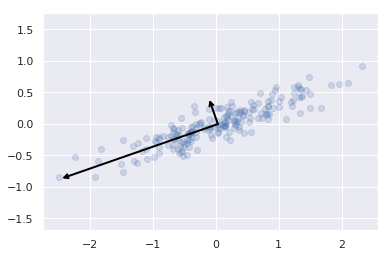

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='black',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Transforming from original data axes to principal axes

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='black',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

[(-3, 3.1),
 Text(0, 0.5, 'component 2'),
 (-5, 5),
 Text(0.5, 0, 'component 1'),
 Text(0.5, 1.0, 'principal components')]

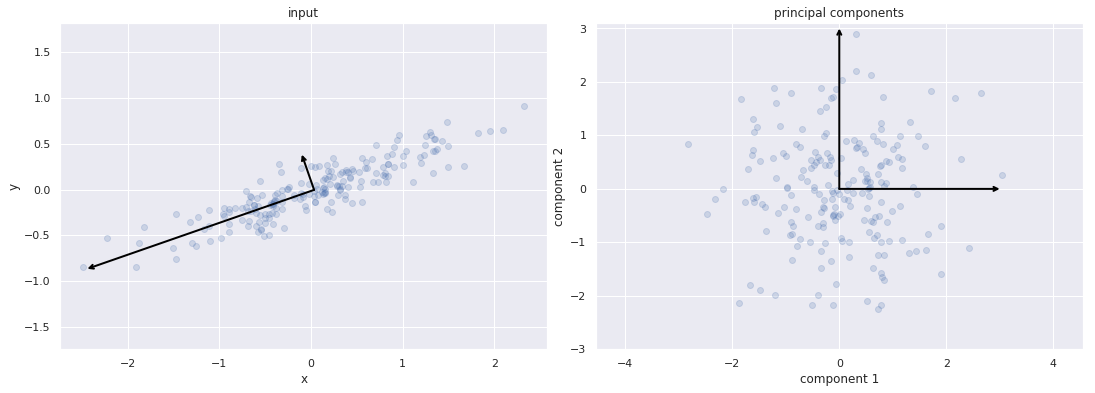

In [8]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

#### How PCA works in dimensionality reduction

PCA works by choosing the main principle components (those that have the largest variance), resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

The information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.

Despite reducing the dimension of the data, the overall relationship between the data points are mostly preserved.

We will reduce the example above to a single dimension: 



In [9]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


We perform an inverse transform of the reduced data and plot it alongside the original data

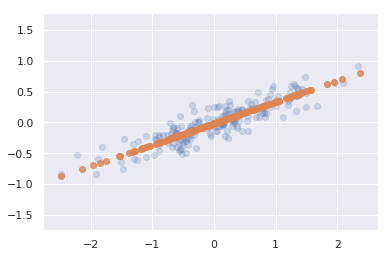

In [10]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

### Example PCA: Hand Written Digits

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The data consists of 8x8 pixel images (64 dimensions). We will use PCA to project them to a more managable number of dimensions (2)

In [12]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


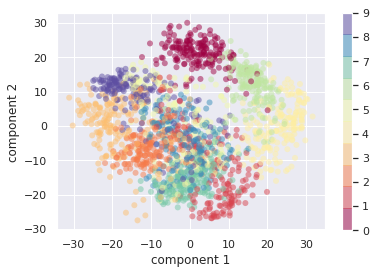

In [13]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

#### Choosing the number of Components

To choose the appropriate number of components, we can look at the cummulative explained ratio. 

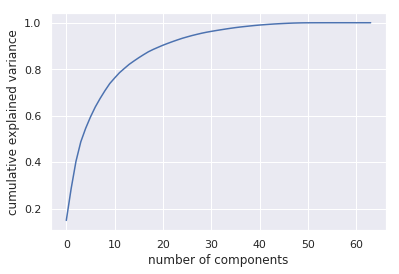

In [14]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

From the chart, we can see that the first 10 components contains 75% of the variance, and the first 20 components provide up to 90% of the variance. 

### PCA in Noise Filtering

- We can use PCA to filter noisy data. 
- The intuition behind this reasoning is that any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. 
- If you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

First, let us plot a clean dataset

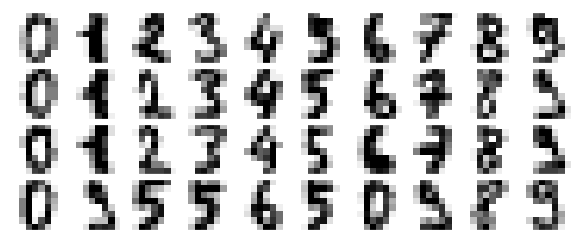

In [15]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Let us add noise to create a noisy dataset

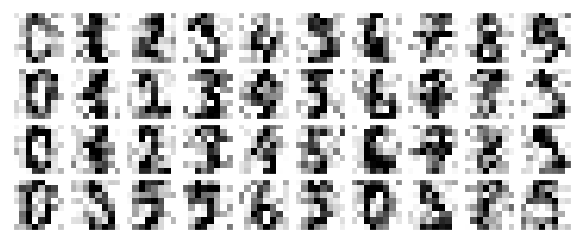

In [16]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

Now we will train the PCA on noisy data and preserve 50% of the variance. We will then print out the number of principal components that are needed to preserve that level of variance. 

In [17]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

In this case, to preserve 50% of variance, we need to use 12 principal components. 

We apply PCA, then use inverse transform to recontruct the components. 

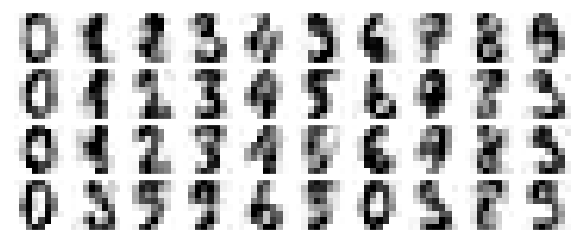

In [18]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

### Example: Eigenfaces

In [19]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)


['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


PCA with 150 primary components

In [20]:
from sklearn.decomposition import PCA
pca = PCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Visualizing the first 150 primary components. These are also known as eigenvectors, so images that have been subjected to this type of transformation are known as eigenfaces. 

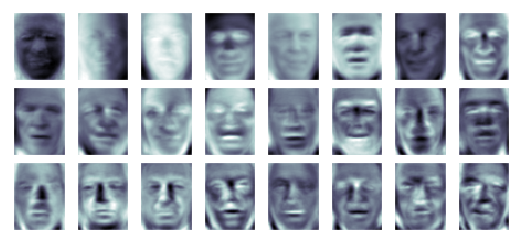

In [21]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

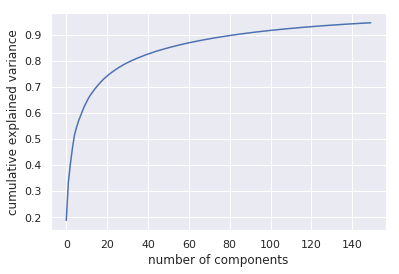

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that 150 components account for just over 90% of the variance

Comparing input images and reconstructed images

In [26]:
# Compute the components and projected faces
pca = PCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

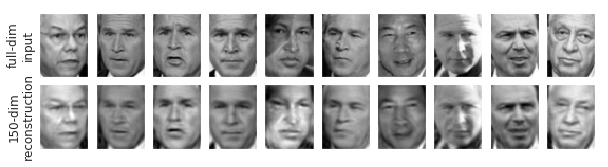

In [27]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

## Summary

PCA is useful for
- Dimentionality Reduction
- Visualization of High-dimensional data
- Noise Reduction

Given any high-dimensional dataset, we can use PCA to:
- visualize the relationship between points (as we did with the digits), 
- to understand the main variance in the data (as we did with the eigenfaces),
- to understand the intrinsic dimensionality (by plotting the explained variance ratio).

PCA's main weakness is that it tends to be highly affected by outliers in the data. We can use `SparsePCA`, which introduces a regularization term. 